# Loading Dataset

In [1]:
! pip install datasets
from datasets import load_dataset

ds = load_dataset("rajpurkar/squad")

In [2]:
import pandas as pd
pd.DataFrame(ds["train"][:5])

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'..."
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,{'text': ['a Marian place of prayer and reflec...
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,{'text': ['a golden statue of the Virgin Mary'...


In [3]:
lengths = pd.DataFrame([len(answer["text"][0].split()) for answer in ds["train"][:]["answers"]])
lengths.describe()

,0
count,87599.000000
mean,3.162159
std,3.392334
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,43.000000


(array([6.5710e+04, 1.0425e+04, 4.3770e+03, 2.3530e+03, 1.4240e+03,
        9.8100e+02, 7.4000e+02, 4.8800e+02, 3.8900e+02, 2.8500e+02,
        2.8600e+02, 9.6000e+01, 3.4000e+01, 9.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1. ,  3.1,  5.2,  7.3,  9.4, 11.5, 13.6, 15.7, 17.8, 19.9, 22. ,
        24.1, 26.2, 28.3, 30.4, 32.5, 34.6, 36.7, 38.8, 40.9, 43. ]),
 <BarContainer object of 20 artists>)

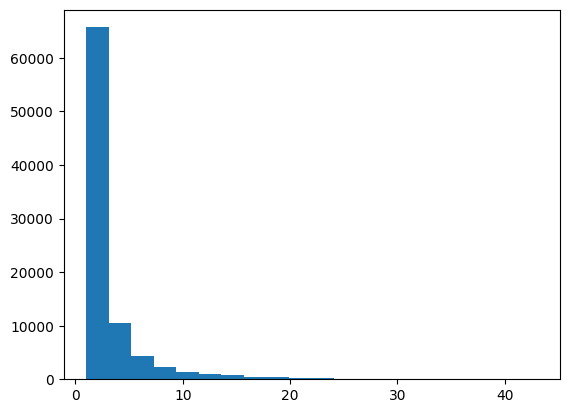

In [4]:
import matplotlib.pyplot as plt

plt.hist(lengths[0], bins=20)

In [5]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [6]:
def preprocess(example):
    tokenized = tokenizer(
        example["question"],
        example["context"],
        truncation="only_second",
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized.pop("offset_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = tokenized.sequence_ids(i)
        sample_idx = sample_mapping[i]
        answers = example["answers"][sample_idx]
        
        if len(answers["answer_start"]) == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
            continue

        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            start_positions.append(token_start_index - 1)

            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            end_positions.append(token_end_index + 1)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    return tokenized

encoded = ds.map(
    preprocess,
    batched=True,
    remove_columns=ds["train"].column_names,
)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [7]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
model = model.to("cuda")

In [9]:
!pip install tf-keras

In [16]:
encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 88524
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 10784
    })
})

In [19]:
from transformers import TrainingArguments, Trainer
import logging

logging.basicConfig(level=logging.DEBUG)  # Set to DEBUG for verbose logs

args = TrainingArguments(
    output_dir="bert-squad/",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    save_steps=500,
    logging_dir="logs/",
    logging_steps=10,
    fp16=True,
    report_to="tensorboard",  # Specify 'tensorboard' for TensorBoard
    max_grad_norm=1.0,
    learning_rate=5e-6,
    weight_decay=0.01

)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded["train"].select(range(20000)),
    eval_dataset=encoded["validation"].select(range(4000)),
)

d:\program_files\anaconda3\envs\torch_gpu\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
trainer.train( )

  0%|          | 0/1250 [00:00<?, ?it/s]

{'loss': 5.6906, 'grad_norm': 5.816143035888672, 'learning_rate': 4.964e-06, 'epoch': 0.01}
{'loss': 5.4943, 'grad_norm': 6.691579341888428, 'learning_rate': 4.924000000000001e-06, 'epoch': 0.02}
{'loss': 5.3563, 'grad_norm': 6.652472496032715, 'learning_rate': 4.884e-06, 'epoch': 0.02}
{'loss': 5.175, 'grad_norm': 6.371222019195557, 'learning_rate': 4.8440000000000005e-06, 'epoch': 0.03}
{'loss': 4.9709, 'grad_norm': 5.715554237365723, 'learning_rate': 4.804e-06, 'epoch': 0.04}
{'loss': 4.7523, 'grad_norm': 12.519432067871094, 'learning_rate': 4.7640000000000005e-06, 'epoch': 0.05}
{'loss': 4.6073, 'grad_norm': 5.671901702880859, 'learning_rate': 4.724e-06, 'epoch': 0.06}
{'loss': 4.4784, 'grad_norm': 5.425264835357666, 'learning_rate': 4.684e-06, 'epoch': 0.06}
{'loss': 4.4598, 'grad_norm': 6.248517990112305, 'learning_rate': 4.644e-06, 'epoch': 0.07}
{'loss': 4.2997, 'grad_norm': 6.079148769378662, 'learning_rate': 4.604e-06, 'epoch': 0.08}
{'loss': 4.1835, 'grad_norm': 6.1350760459

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 2.4667153358459473, 'eval_runtime': 917.6264, 'eval_samples_per_second': 4.359, 'eval_steps_per_second': 0.272, 'epoch': 0.4}
{'loss': 2.6061, 'grad_norm': 21.133045196533203, 'learning_rate': 2.9720000000000005e-06, 'epoch': 0.41}
{'loss': 2.4227, 'grad_norm': 24.208749771118164, 'learning_rate': 2.9320000000000005e-06, 'epoch': 0.42}
{'loss': 2.5263, 'grad_norm': 19.10491943359375, 'learning_rate': 2.8920000000000004e-06, 'epoch': 0.42}
{'loss': 2.4112, 'grad_norm': 19.734045028686523, 'learning_rate': 2.8520000000000004e-06, 'epoch': 0.43}
{'loss': 2.4635, 'grad_norm': 16.35801887512207, 'learning_rate': 2.8120000000000004e-06, 'epoch': 0.44}
{'loss': 2.5145, 'grad_norm': 19.287002563476562, 'learning_rate': 2.7720000000000003e-06, 'epoch': 0.45}
{'loss': 2.5003, 'grad_norm': 26.03224754333496, 'learning_rate': 2.7320000000000003e-06, 'epoch': 0.46}
{'loss': 2.369, 'grad_norm': 18.096752166748047, 'learning_rate': 2.6920000000000002e-06, 'epoch': 0.46}
{'loss': 2.3211,

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 2.1524198055267334, 'eval_runtime': 914.9077, 'eval_samples_per_second': 4.372, 'eval_steps_per_second': 0.273, 'epoch': 0.8}
{'loss': 2.2126, 'grad_norm': 24.3334903717041, 'learning_rate': 9.72e-07, 'epoch': 0.81}
{'loss': 2.1813, 'grad_norm': 19.932424545288086, 'learning_rate': 9.320000000000001e-07, 'epoch': 0.82}
{'loss': 2.0285, 'grad_norm': 28.832059860229492, 'learning_rate': 8.920000000000001e-07, 'epoch': 0.82}
{'loss': 2.4332, 'grad_norm': 20.56043243408203, 'learning_rate': 8.520000000000001e-07, 'epoch': 0.83}
{'loss': 2.0936, 'grad_norm': 25.302898406982422, 'learning_rate': 8.12e-07, 'epoch': 0.84}
{'loss': 2.2786, 'grad_norm': 16.42813491821289, 'learning_rate': 7.720000000000001e-07, 'epoch': 0.85}
{'loss': 2.1641, 'grad_norm': 21.358415603637695, 'learning_rate': 7.32e-07, 'epoch': 0.86}
{'loss': 2.1142, 'grad_norm': 16.416662216186523, 'learning_rate': 6.92e-07, 'epoch': 0.86}
{'loss': 2.0578, 'grad_norm': 20.5649356842041, 'learning_rate': 6.52e-07, '

TrainOutput(global_step=1250, training_loss=2.753815994262695, metrics={'train_runtime': 45401.1931, 'train_samples_per_second': 0.441, 'train_steps_per_second': 0.028, 'total_flos': 3919451351040000.0, 'train_loss': 2.753815994262695, 'epoch': 1.0})

In [21]:
import evaluate
squad_metric = evaluate.load("squad")
predictions = trainer.predict(encoded["validation"])

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/metrics/evaluate-metric/squad/evaluate-metric/squad.py HTTP/11" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /spaces/evaluate-metric/squad/resolve/v0.4.3/squad.py HTTP/11" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /spaces/evaluate-metric/squad/resolve/main/squad.py HTTP/11" 200 0
DEBUG:filelock:Attempting to acquire lock 2329089782736 on C:\Users\ahmad\.cache\huggingface\evaluate\downloads\75d8b4ad16decd019d81193e848cafd38b43f7c29e53c1370b36245e7ed5bc20.75eb293ae4616c49434e33eee8b713512f402f6972eec62e2a53b88afc40a4cc.py.lock
DEBUG:filelock:Lock 2329089782736 acquired on C:\Users\ahmad\.cache\hug

DEBUG:filelock:Attempting to release lock 2329089782736 on C:\Users\ahmad\.cache\huggingface\evaluate\downloads\75d8b4ad16decd019d81193e848cafd38b43f7c29e53c1370b36245e7ed5bc20.75eb293ae4616c49434e33eee8b713512f402f6972eec62e2a53b88afc40a4cc.py.lock
DEBUG:filelock:Lock 2329089782736 released on C:\Users\ahmad\.cache\huggingface\evaluate\downloads\75d8b4ad16decd019d81193e848cafd38b43f7c29e53c1370b36245e7ed5bc20.75eb293ae4616c49434e33eee8b713512f402f6972eec62e2a53b88afc40a4cc.py.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /spaces/evaluate-metric/squad/resolve/main/compute_score.py HTTP/11" 200 0
DEBUG:filelock:Attempting to acquire lock 2329092664144 on C:\Users\ahmad\.cache\huggingface\evaluate\downloads\7454265caca9864b599b08661b2f7afd278c2a7de7a35534aced5317e40e46ea.9900c7ed02c782bfb7a87d4eae463bb2043ad38abf7893d46495a3af7d9adf01.py.lock
DEBUG:filelock:Lock 2329092664144 acquired 

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [ ]:
import numpy as np

def get_answer(example, start_idx, end_idx, tokenizer):
    inputs = tokenizer(
        example["question"],
        example["context"],
        truncation="only_second",
        max_length=384,
        stride=128,
        return_overflowing_tokens=False,
        return_offsets_mapping=True,
        padding="max_length",
    )
    offsets = inputs["offset_mapping"]
    start_char = offsets[start_idx][0]
    end_char = offsets[end_idx][1]
    return example["context"][start_char:end_char]


In [ ]:
preds = []
refs = []
for i, example in enumerate(ds["validation"]):
    start = np.argmax(predictions.predictions[0][i])
    end = np.argmax(predictions.predictions[1][i])
    answer = get_answer(example, start, end, tokenizer)
    preds.append({"id": example["id"], "prediction_text": answer})
    refs.append({"id": example["id"], "answers": example["answers"]})


In [ ]:
results = squad_metric.compute(predictions=preds, references=refs)
results

In [ ]:
import torch
sample_data = [
    {
        "context": "The capital of France is Paris. It is known for its art, fashion, and culture.",
        "question": "What is the capital of France?",
        "answer": "Paris",
    },
    {
        "context": "The capital of France is Paris. It is known for its art, fashion, and culture.",
        "question": "What is the capital of France?",
        "answer": "Paris",
    },
    {
        "context": "Python is a high-level programming language used for general-purpose programming.",
        "question": "What is Python used for?",
        "answer": "general-purpose programming",
    },
    {
        "context": "Albert Einstein developed the theory of relativity, which revolutionized modern physics.",
        "question": "Who developed the theory of relativity?",
        "answer": "Albert Einstein",
    },
    {
        "context": "The Eiffel Tower is located in Paris, France. It is a global cultural icon of France.",
        "question": "Where is the Eiffel Tower located?",
        "answer": "Paris, France",
    },
]
sample_encodings = tokenizer(
    [item["question"] for item in sample_data],
    [item["context"] for item in sample_data],
    truncation="only_second",
    padding="max_length",
    max_length=384,
    return_tensors="pt",
)
with torch.no_grad():
    outputs = model(**sample_encodings)

start_logits = outputs.start_logits
end_logits = outputs.end_logits

# Get the predicted start and end token indices
start_indices = torch.argmax(start_logits, dim=1)
end_indices = torch.argmax(end_logits, dim=1)

predicted_answers = []
for i, (start_idx, end_idx) in enumerate(zip(start_indices, end_indices)):
    start_char = sample_encodings['offset_mapping'][i][start_idx.item()][0]
    end_char = sample_encodings['offset_mapping'][i][end_idx.item()][1]
    predicted_answer = sample_data[i]["context"][start_char:end_char]
    predicted_answers.append(predicted_answer)


In [ ]:
for i, item in enumerate(sample_data):
    print(f"Context: {item['context']}")
    print(f"Question: {item['question']}")
    print(f"Ground Truth Answer: {item['answer']}")
    print(f"Predicted Answer: {predicted_answers[i]}")
    print("-" * 80)